# Mini Use Case CNN - convolutional neural network

Hier befindet sich der [Beispielcode](./CNN_added_LRP.ipynb) für das Implementieren eines Autoencoders um ein ML-Modell zu trainieren. 

In [1]:
# Importieren der Notwendigen Bibliotheken 
# Diese können über die requirements datei installiert werden.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import cv2
from tf_explain.core.grad_cam import GradCAM

2022-03-30 19:14:51.656437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-03-30 19:14:51.656457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Datenaufbereitung

In [2]:
path_string = "data/"                               # Pfad zu dem Ordner der Trainingsdaten
image_path = pathlib.Path(path_string) 
data_dir = image_path
image_count = len(list(image_path.glob('*/*.JPG'))) # Hier wird das Bildformat definiert. Andere möglichkeiten können auch .PNG, .jpg, ... sein 
print("Es wurden {} Bilder gefunden." .format(image_count))                                  # Gibt aus wie viele Bilder gedunden wurden. 


Es wurden 2062 Bilder gefunden


In [3]:
#Angeben wie groß die Batch und Bildgröße für das CNN-Model sein soll

batch_size = 32
img_height = 100
img_width = 100

In [7]:
# Datensatz erstellen
# 80/20 Split 

print("**** Tensorflo Output ****")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training", 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



print("\n**** Datensatz Zusammenfassung ****")
class_names = train_ds.class_names
num_classes = len(class_names)
print("Es werden {} Klassen verwendet." .format(num_classes))
print("Folgende Klassen Namen wurden gefunden: {}" .format(class_names))


**** Tensorflo Output ****
Found 2062 files belonging to 10 classes.
Using 1650 files for training.
Found 2062 files belonging to 10 classes.
Using 412 files for validation.


**** Datensatz Zusammenfassung ****
Es werden 10 Klassen verwendet.
Folgende Klassen Namen wurden gefunden: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


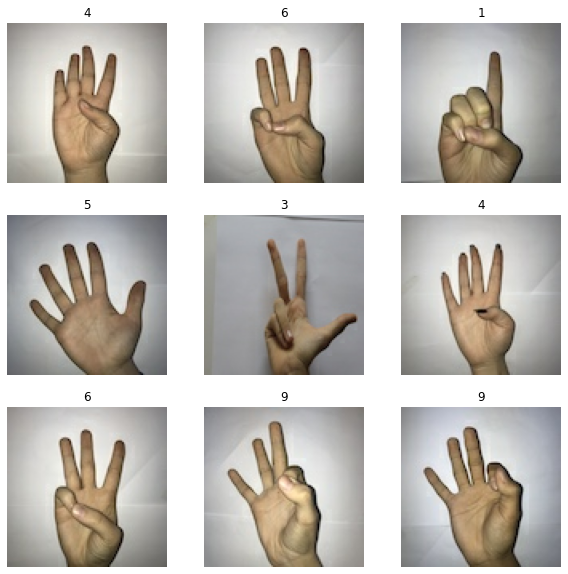

In [9]:
# Ausgabe von Beispielbildern des Datensatzes

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
# Bild augmentation 

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Anwenden der verschiedenen Augmentation Styles 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(img_height, img_width,3)),    # Bild Flippen (Vertikal / Spiegeln)
    layers.experimental.preprocessing.RandomRotation(0.1),                                              # Bild drehen
    layers.experimental.preprocessing.RandomZoom(0.1),                                                  # Bild hinein Zoomen
    layers.experimental.preprocessing.RandomContrast(0.1),                                              # Kontrast ändern
  ]
)


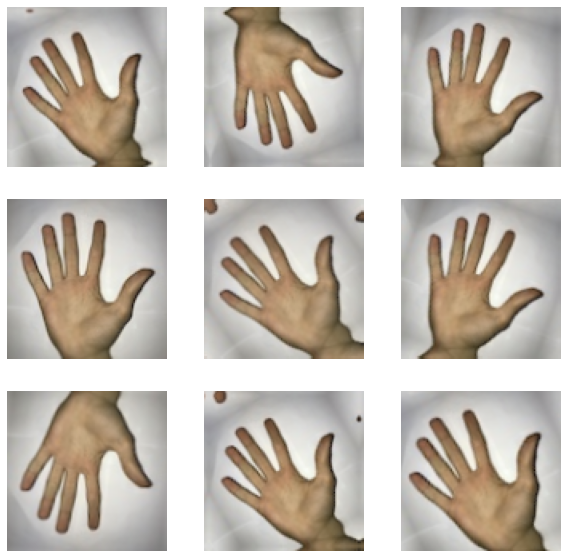

In [11]:
# Anzeigen einiger augmentierter Bilder

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


## Model Definieren

In [12]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
# Hier wird das Model kompiliert und eine Zusammenfassung ausgegeben

# kompilieren 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Zusammenfassung
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [ ]:
# Trainieren des Models

# Angabe der Trainingszyklen
epochs = 80

# Trainingsfunktion
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)


## Ergebnis

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Testen

In [ ]:
import cv2
cv2.namedWindow("TEST",0)

i = 0
for filename in os.listdir("demo"):
    img = cv2.imread(os.path.join("demo/",filename))
    #img = resize(img, (width, height))
    if img is None:
        print(os.path.join("demo/",filename))
        break
    else:
        
        image = img
        np_image_data = np.asarray(image)
        image = np.expand_dims(image, axis=0)
        predictions = model.predict(image)
        score = tf.nn.softmax(predictions)
        print("Auf dem Bild ist zu {:.2f}% eine {} zu sehen.".format(100 * np.max(score), class_names[np.argmax(score)]))    

        cv2.imshow("TEST", img)
        if cv2.waitKey(0) & 0xFF == ord('q'):    
            break


cv2.destroyAllWindows()

# Layer-wise relevance Propagation -> trying https://tf-explain.readthedocs.io/en/latest/usage.html implementation

In [ ]:

explainer = GradCAM()

i = 0
for filename in os.listdir("demo"):
    img = cv2.imread(os.path.join("demo/",filename))
    #img = resize(img, (width, height))
    if img is None:
        print(os.path.join("demo/",filename))
        break
    else:
        img = tf.keras.preprocessing.image.load_img("demo/"+filename, target_size=(100, 100))
        img = tf.keras.preprocessing.image.img_to_array(img)
        data = ([img], None)
        grid = explainer.explain(data, model, class_index=1)  
        vis = np.concatenate((img, grid), axis=1)
        explainer.save(vis, ".", "visu/"+filename)

# Camera

In [ ]:

cv2.namedWindow("cam",0)

cap = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = cap.read()
  
    # resize to 100x100
    cropped_full = frame[40:440, 120:620]
    down_points = (100, 100)
    cropped = cv2.resize(cropped_full, down_points,interpolation= cv2.INTER_LINEAR)

    # Display the resulting frame
    image = np.expand_dims(cropped, axis=0)
    predictions = model.predict(image)
    score = tf.nn.softmax(predictions)
    #print("Auf dem Bild ist zu {:.2f}% eine {} zu sehen.".format(100 * np.max(score), class_names[np.argmax(score)]))    

    cv2.putText(cropped_full, str("Auf dem Bild ist zu {:.2f}% eine {} zu sehen.".format(100 * np.max(score), class_names[np.argmax(score)])),
               (20, 30),
                1, 1, (0,0,0), 1)


    # Start explainer
    data = ([cropped], None)
    grid = explainer.explain(data, model, class_index=int(class_names[np.argmax(score)]))
    grid = cv2.resize(grid, (400,400) ,interpolation= cv2.INTER_AREA)

    vis = np.concatenate((cropped_full, grid), axis=1)

    cv2.imshow('cam', vis)

    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  


  
# After the loop release the cap object
cap.release()
cv2.destroyAllWindows()